In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
import asyncio
from concurrent.futures import ThreadPoolExecutor
import os
from groq import Groq
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import json
from langgraph.graph import Graph, StateGraph, END, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import logging
from typing import Dict, Any
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from datetime import date

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [15]:
load_dotenv()

True

In [16]:
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [17]:
# Define State
class BankReconciliationState(BaseModel):
    bank_data: Any
    erp_data: Optional[Any] = None
    columns: Optional[dict] = None  # make optional, to be filled later

In [18]:
from pydantic import BaseModel, Field

class ColumnSchema(BaseModel):
    transaction_date: str = Field(..., description="Column name for transaction date")
    debit: str = Field(..., description="Column name for debit amount")
    credit: str = Field(..., description="Column name for credit amount")


In [19]:
structured_model_column = llm.with_structured_output(ColumnSchema)

In [20]:
# Node function
def find_columns(state: BankReconciliationState):
    bank_data = pd.read_csv(state.bank_data)
    subset_data = bank_data.head(5)  # take first 5 rows dynamically
    prompt = f"""
    From the following dataset, identify which column corresponds to:
    - transaction_date
    - debit
    - credit

    Dataset sample:
    {subset_data.to_dict(orient='records')}
    """

    result = structured_model_column.invoke(prompt)
    return {'columns': result}

In [21]:
# Build the graph
graph = StateGraph(BankReconciliationState)

graph.add_node('find_columns', find_columns)
graph.add_edge(START, 'find_columns')
graph.add_edge('find_columns', END)

# Compile workflow
workflow = graph.compile()


In [22]:
workflow

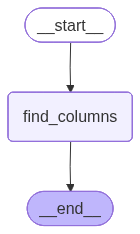

In [23]:
from IPython.display import Image, display
Image(workflow.get_graph().draw_mermaid_png())

In [24]:
intial_state={
    'bank_data': "Dataset/Pubali # 41774.csv"
}
result = workflow.invoke(intial_state)

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [25]:
columns = result["columns"]

In [26]:
# Option 1: Access each value individually
transaction_date = columns.transaction_date
debit = columns.debit
credit = columns.credit

print(transaction_date, "\n", debit, "\n", credit)

TRN DATE 
 DEBIT 
 CREDIT
